In [1]:
# Standard library imports
import glob
import os
import random
from collections import defaultdict
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# Machine learning imports
import timm
from sklearn.manifold import TSNE

# Image processing imports
from PIL import Image

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Configuration ---
current_dir = Path.cwd()
project_root = current_dir.parents[1]

CONFIG = {
    # --- Path & System ---
    # Directory containing the dataset
    "DATA_DIR": project_root / "data" / "classification_dataset",
    "OUTPUT_DIR": project_root / "results" / "classification",  # Directory to save results
    "DEVICE": "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu",

    # --- Models & Backbones to Test ---
    "MODELS_TO_TEST": ["proto", "match", "finetune"],
    "BACKBONES_TO_TEST": [
        "tf_efficientnetv2_s.in21k_ft_in1k",
        "resnet18.a1_in1k",
        "vit_tiny_patch16_224.augreg_in21k_ft_in1k",
    ],

    # --- Evaluation Parameters ---
    "K_SHOTS_TO_TEST": [1, 2, 3, 5, 10],
    "N_EVAL_EPISODES": 100,  # Number of episodes for robust accuracy
    "TSNE_SAMPLE_SIZE": 1500,  # Max samples for t-SNE plot to keep it fast

    # --- Fine-Tuning Parameters ---
    "FINETUNE_EPOCHS": 10,
    "FINETUNE_LR": 1e-3,
}

In [3]:
# --- Simplified Data Handling ---
def load_dataset():
    """Load and organize all image paths by class."""
    print("Loading dataset...")
    data_dir = CONFIG["DATA_DIR"]
    all_paths = defaultdict(list)
    
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    class_to_idx = {name: i for i, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        # Get all common image formats
        patterns = ["*.jpg", "*.png", "*.jpeg"]
        for pattern in patterns:
            all_paths[class_name].extend(glob.glob(os.path.join(class_dir, pattern)))
    
    total_images = sum(len(paths) for paths in all_paths.values())
    print(f"Found {len(class_names)} classes, {total_images} total images")
    
    return all_paths, class_to_idx

def create_episode_split(all_image_paths, k_shot):
    """Create support and query splits for few-shot learning episode."""
    support_paths, support_labels = [], []
    query_paths, query_labels = [], []
    
    for class_name, paths in all_image_paths.items():
        if len(paths) < 2:  # Need at least 1 support + 1 query
            continue
            
        shuffled_paths = random.sample(paths, len(paths))
        actual_k = min(k_shot, len(shuffled_paths) - 1)
        
        if actual_k > 0:
            support_paths.extend(shuffled_paths[:actual_k])
            support_labels.extend([class_name] * actual_k)
            query_paths.extend(shuffled_paths[actual_k:])
            query_labels.extend([class_name] * len(shuffled_paths[actual_k:]))
    
    return (support_paths, support_labels), (query_paths, query_labels)

In [4]:
# --- Simplified Embedding Computation ---
def create_feature_extractor(backbone_name):
    """Create feature extractor and transform for given backbone."""
    model = timm.create_model(backbone_name, pretrained=True, num_classes=0)
    data_config = timm.data.resolve_model_data_config(model)
    transform = timm.data.create_transform(**data_config)
    return model.to(CONFIG["DEVICE"]), transform

@torch.no_grad()
def compute_all_embeddings(backbone_name, all_image_paths):
    """Compute normalized embeddings for all images."""
    print(f"\nComputing embeddings with {backbone_name}...")
    
    feature_extractor, transform = create_feature_extractor(backbone_name)
    feature_extractor.eval()
    
    # Flatten all image paths
    all_paths = [path for paths in all_image_paths.values() for path in paths]
    path_to_embedding = {}
    
    batch_size = 128
    for i in tqdm(range(0, len(all_paths), batch_size), desc="Processing images"):
        batch_paths = all_paths[i:i+batch_size]
        
        # Load and transform images
        images = [Image.open(path).convert("RGB") for path in batch_paths]
        img_tensors = torch.stack([transform(img) for img in images]).to(CONFIG["DEVICE"])
        
        # Extract and normalize embeddings
        embeddings = feature_extractor(img_tensors)
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Store embeddings
        for path, emb in zip(batch_paths, normalized_embeddings):
            path_to_embedding[path] = emb.cpu()
    
    embedding_dim = list(path_to_embedding.values())[0].shape[0]
    return path_to_embedding, embedding_dim

In [5]:
# --- Simplified Few-Shot Models ---
class PrototypicalNetwork(nn.Module):
    """Prototypical Networks: classify based on prototype distances."""
    
    def forward(self, support_embs, support_labels, query_embs):
        # Group embeddings by class and compute prototypes
        support_by_class = defaultdict(list)
        for emb, label in zip(support_embs, support_labels):
            support_by_class[label].append(emb)
        
        prototypes = {}
        for class_name, embs in support_by_class.items():
            prototype = torch.mean(torch.stack(embs), dim=0)
            prototypes[class_name] = F.normalize(prototype, p=2, dim=0)
        
        # Compute similarities (cosine similarity for normalized vectors)
        prototype_tensor = torch.stack(list(prototypes.values()))
        similarities = torch.matmul(query_embs, prototype_tensor.T)
        
        return similarities, list(prototypes.keys())

class MatchingNetwork(nn.Module):
    """Matching Networks: weighted attention over support samples."""
    
    def forward(self, support_embs, support_labels, query_embs):
        # Compute attention weights (cosine similarity)
        similarities = F.softmax(torch.matmul(query_embs, support_embs.T), dim=1)
        
        # Create one-hot encoding for support labels
        unique_labels = sorted(list(set(support_labels)))
        label_to_idx = {label: i for i, label in enumerate(unique_labels)}
        
        support_one_hot = F.one_hot(
            torch.tensor([label_to_idx[label] for label in support_labels]),
            num_classes=len(unique_labels)
        ).float().to(query_embs.device)
        
        # Aggregate similarities by class
        predictions = torch.matmul(similarities, support_one_hot)
        return predictions, unique_labels

class FineTuningModel(nn.Module):
    """Fine-tuning baseline: train linear classifier on support set."""
    
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.device = CONFIG["DEVICE"]
    
    def forward(self, support_embs, support_labels, query_embs, class_to_idx):
        # Create fresh classifier for each episode
        classifier = nn.Linear(self.embedding_dim, self.num_classes).to(self.device)
        optimizer = optim.Adam(classifier.parameters(), lr=CONFIG["FINETUNE_LR"])
        criterion = nn.CrossEntropyLoss()
        
        # Convert labels to indices
        support_indices = torch.tensor([class_to_idx[label] for label in support_labels], 
                                     device=self.device)
        
        # Train on support set
        classifier.train()
        for _ in range(CONFIG["FINETUNE_EPOCHS"]):
            optimizer.zero_grad()
            outputs = classifier(support_embs)
            loss = criterion(outputs, support_indices)
            loss.backward()
            optimizer.step()
        
        # Evaluate on query set
        classifier.eval()
        with torch.no_grad():
            outputs = classifier(query_embs)
        
        return outputs, list(class_to_idx.keys())

In [6]:
# --- Simplified Evaluation ---
def evaluate_model(model, model_name, k_shot, all_image_paths, class_to_idx, path_to_embedding):
    """Evaluate model performance over multiple episodes."""
    print(f"Evaluating {model_name} with {k_shot}-shot...")
    
    accuracies = []
    device = CONFIG["DEVICE"]
    
    for _ in tqdm(range(CONFIG["N_EVAL_EPISODES"]), desc=f"{model_name} K={k_shot}"):
        # Create episode
        support_set, query_set = create_episode_split(all_image_paths, k_shot)
        (support_paths, support_labels), (query_paths, query_labels) = support_set, query_set
        
        if not query_paths or not support_paths:
            continue
        
        # Get embeddings
        support_embs = torch.stack([path_to_embedding[p] for p in support_paths]).to(device)
        query_embs = torch.stack([path_to_embedding[p] for p in query_paths]).to(device)
        
        # Run model
        if isinstance(model, FineTuningModel):
            predictions, class_order = model(support_embs, support_labels, query_embs, class_to_idx)
        else:
            predictions, class_order = model(support_embs, support_labels, query_embs)
        
        # Calculate accuracy
        predicted_indices = predictions.argmax(dim=1).cpu()
        predicted_labels = [class_order[i] for i in predicted_indices]
        
        correct = sum(1 for pred, true in zip(predicted_labels, query_labels) if pred == true)
        accuracy = (correct / len(query_labels)) * 100 if query_labels else 0
        accuracies.append(accuracy)
    
    # Calculate statistics
    mean_acc = np.mean(accuracies) if accuracies else 0
    confidence_interval = 1.96 * np.std(accuracies) / np.sqrt(len(accuracies)) if len(accuracies) > 1 else 0
    
    print(f"  {model_name}: {mean_acc:.2f}% (±{confidence_interval:.2f})")
    
    return {
        "model_name": model_name,
        "avg_accuracy_percent": mean_acc,
        "confidence_interval_percent": confidence_interval,
        "shots": k_shot
    }

In [7]:
# --- Simplified Visualization ---
def plot_accuracy_results(results_df, backbone_name):
    """Generate accuracy comparison plot."""
    print(f"Generating plot for {backbone_name}...")
    
    if results_df.empty:
        print("No results to plot")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Create consistent color mapping
    unique_models = sorted(results_df['model_name'].unique())
    colors = sns.color_palette("tab10", len(unique_models))
    color_map = dict(zip(unique_models, colors))
    
    # Plot lines with error bars
    for model_name, group in results_df.groupby('model_name'):
        color = color_map[model_name]
        plt.errorbar(group['shots'], group['avg_accuracy_percent'], 
                    yerr=group['confidence_interval_percent'],
                    fmt='-o', label=model_name, color=color, capsize=5, markersize=8)
        
        # Add confidence interval shading
        plt.fill_between(group['shots'],
                        group['avg_accuracy_percent'] - group['confidence_interval_percent'],
                        group['avg_accuracy_percent'] + group['confidence_interval_percent'],
                        color=color, alpha=0.2)
    
    plt.title(f'Few-Shot Classification Accuracy - {backbone_name}', fontsize=14)
    plt.xlabel('Number of Shots (K)', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(CONFIG['K_SHOTS_TO_TEST'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    safe_name = backbone_name.replace('.', '_')
    plot_path = os.path.join(CONFIG["OUTPUT_DIR"], f"accuracy_vs_shots_{safe_name}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved plot to {plot_path}")

In [8]:
# --- Simplified t-SNE Visualization ---
def create_tsne_visualization(path_to_embedding, all_image_paths, backbone_name):
    """Create t-SNE visualization of embeddings."""
    print(f"Creating t-SNE visualization for {backbone_name}...")
    
    # Prepare data
    all_paths, all_labels = [], []
    for label, paths in all_image_paths.items():
        all_paths.extend(paths)
        all_labels.extend([label] * len(paths))
    
    # Sample for efficiency
    sample_size = min(len(all_paths), CONFIG["TSNE_SAMPLE_SIZE"])
    if sample_size < 10:
        print("Not enough samples for t-SNE")
        return
    
    sample_indices = random.sample(range(len(all_paths)), sample_size)
    sampled_paths = [all_paths[i] for i in sample_indices]
    sampled_labels = [all_labels[i] for i in sample_indices]
    
    # Get embeddings and run t-SNE
    embeddings = torch.stack([path_to_embedding[p] for p in sampled_paths]).numpy()
    
    perplexity = min(30, sample_size - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, 
                learning_rate='auto', init='pca')
    tsne_results = tsne.fit_transform(embeddings)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    unique_labels = sorted(set(sampled_labels))
    colors = sns.color_palette("hsv", len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        mask = np.array(sampled_labels) == label
        plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.7, s=50)
    
    plt.title(f't-SNE Embedding Visualization - {backbone_name}', fontsize=14)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save plot
    safe_name = backbone_name.replace('.', '_')
    plot_path = os.path.join(CONFIG["OUTPUT_DIR"], f"tsne_visualization_{safe_name}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved t-SNE plot to {plot_path}")

Starting Few-Shot Classification Experiments
Device: mps
Loading dataset...
Found 6 classes, 298 total images

Testing backbone: tf_efficientnetv2_s.in21k_ft_in1k

Computing embeddings with tf_efficientnetv2_s.in21k_ft_in1k...


Processing images: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]



Creating t-SNE visualization for tf_efficientnetv2_s.in21k_ft_in1k...


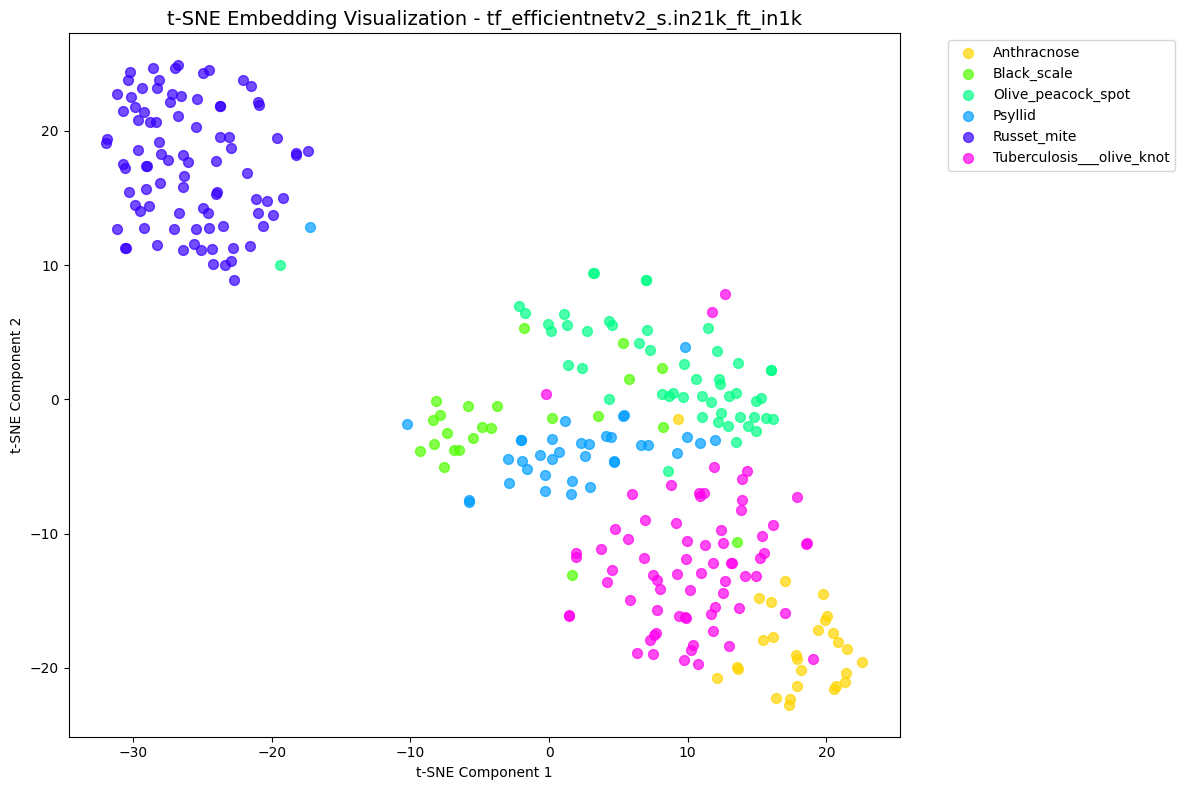

Saved t-SNE plot to /Users/mac/Developer/VScode/Olive Pest Detector/results/classification/tsne_visualization_tf_efficientnetv2_s_in21k_ft_in1k.png

--- 1-shot evaluation ---
Evaluating Prototypical Network with 1-shot...


Prototypical Network K=1: 100%|██████████| 100/100 [00:00<00:00, 408.01it/s]


  Prototypical Network: 67.11% (±1.27)
Evaluating Matching Network with 1-shot...


Matching Network K=1: 100%|██████████| 100/100 [00:00<00:00, 593.27it/s]


  Matching Network: 68.25% (±1.30)
Evaluating Fine-Tuning with 1-shot...


Fine-Tuning K=1: 100%|██████████| 100/100 [00:01<00:00, 91.70it/s]


  Fine-Tuning: 61.51% (±1.31)

--- 2-shot evaluation ---
Evaluating Prototypical Network with 2-shot...


Prototypical Network K=2: 100%|██████████| 100/100 [00:00<00:00, 484.22it/s]


  Prototypical Network: 74.53% (±1.21)
Evaluating Matching Network with 2-shot...


Matching Network K=2: 100%|██████████| 100/100 [00:00<00:00, 767.89it/s]


  Matching Network: 72.67% (±1.19)
Evaluating Fine-Tuning with 2-shot...


Fine-Tuning K=2: 100%|██████████| 100/100 [00:00<00:00, 108.94it/s]


  Fine-Tuning: 69.82% (±1.20)

--- 3-shot evaluation ---
Evaluating Prototypical Network with 3-shot...


Prototypical Network K=3: 100%|██████████| 100/100 [00:00<00:00, 440.63it/s]


  Prototypical Network: 78.78% (±0.86)
Evaluating Matching Network with 3-shot...


Matching Network K=3: 100%|██████████| 100/100 [00:00<00:00, 750.82it/s]


  Matching Network: 77.11% (±0.98)
Evaluating Fine-Tuning with 3-shot...


Fine-Tuning K=3: 100%|██████████| 100/100 [00:00<00:00, 112.16it/s]


  Fine-Tuning: 73.39% (±1.02)

--- 5-shot evaluation ---
Evaluating Prototypical Network with 5-shot...


Prototypical Network K=5: 100%|██████████| 100/100 [00:00<00:00, 390.90it/s]


  Prototypical Network: 83.29% (±0.69)
Evaluating Matching Network with 5-shot...


Matching Network K=5: 100%|██████████| 100/100 [00:00<00:00, 700.95it/s]


  Matching Network: 81.26% (±0.77)
Evaluating Fine-Tuning with 5-shot...


Fine-Tuning K=5: 100%|██████████| 100/100 [00:00<00:00, 112.26it/s]


  Fine-Tuning: 77.84% (±1.08)

--- 10-shot evaluation ---
Evaluating Prototypical Network with 10-shot...


Prototypical Network K=10: 100%|██████████| 100/100 [00:00<00:00, 322.92it/s]


  Prototypical Network: 85.83% (±0.55)
Evaluating Matching Network with 10-shot...


Matching Network K=10: 100%|██████████| 100/100 [00:00<00:00, 700.43it/s]


  Matching Network: 85.94% (±0.61)
Evaluating Fine-Tuning with 10-shot...


Fine-Tuning K=10: 100%|██████████| 100/100 [00:00<00:00, 107.97it/s]



  Fine-Tuning: 82.50% (±0.97)
Generating plot for tf_efficientnetv2_s.in21k_ft_in1k...


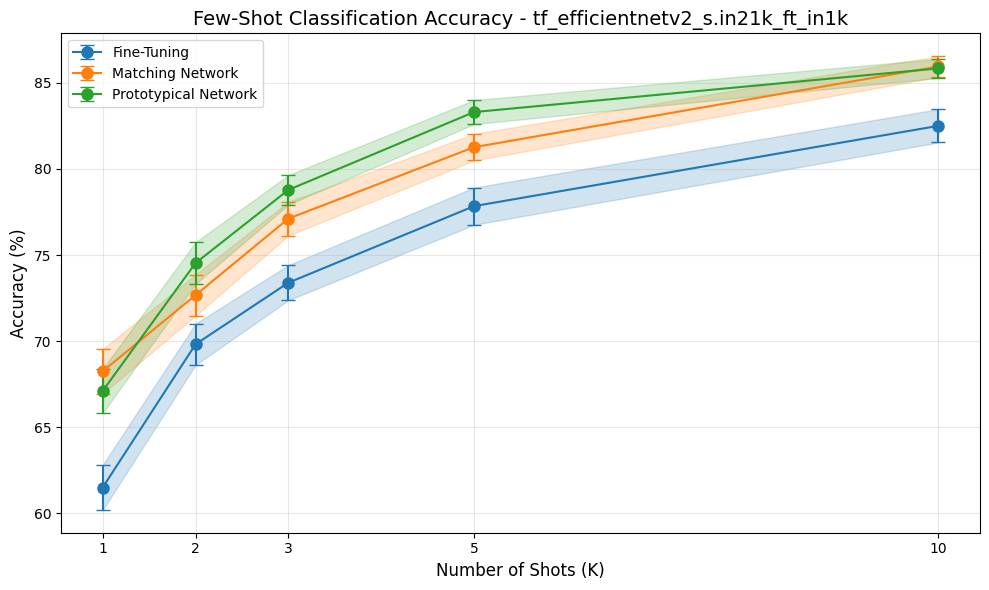

Saved plot to /Users/mac/Developer/VScode/Olive Pest Detector/results/classification/accuracy_vs_shots_tf_efficientnetv2_s_in21k_ft_in1k.png

Testing backbone: resnet18.a1_in1k

Computing embeddings with resnet18.a1_in1k...


Processing images: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]



Creating t-SNE visualization for resnet18.a1_in1k...


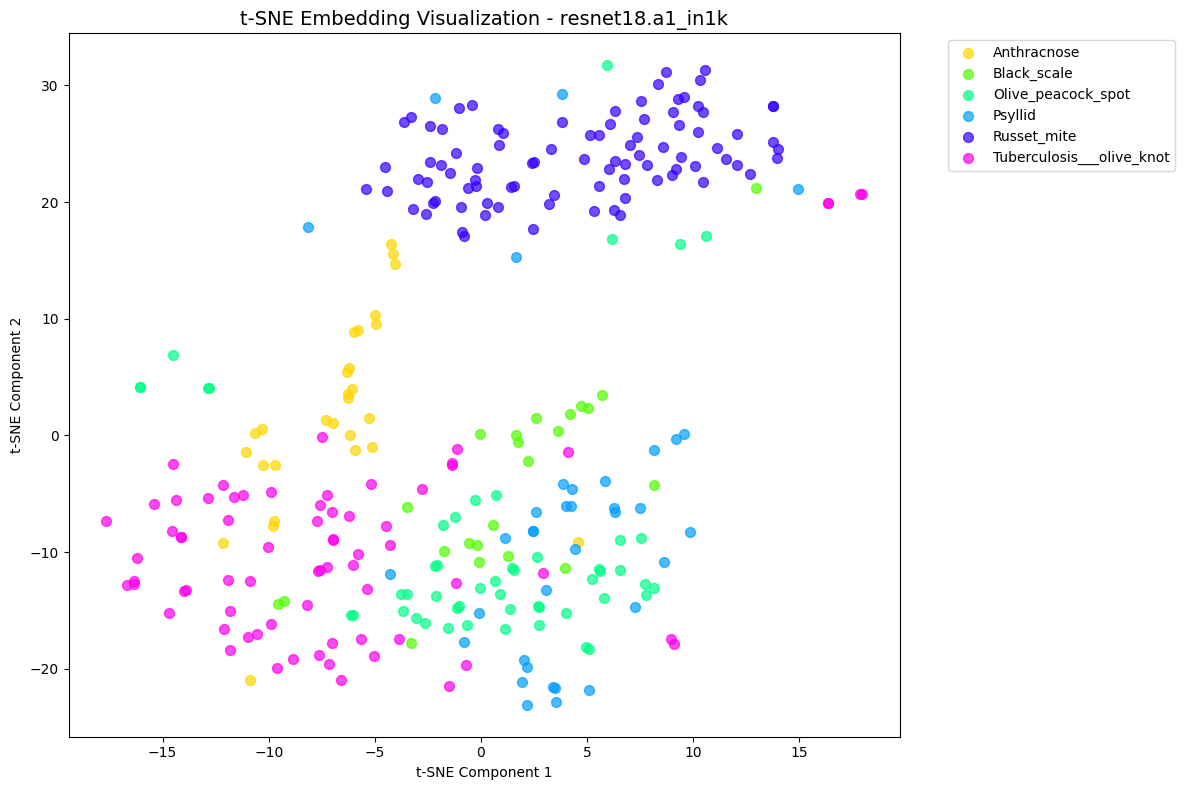

Saved t-SNE plot to /Users/mac/Developer/VScode/Olive Pest Detector/results/classification/tsne_visualization_resnet18_a1_in1k.png

--- 1-shot evaluation ---
Evaluating Prototypical Network with 1-shot...


Prototypical Network K=1: 100%|██████████| 100/100 [00:00<00:00, 501.09it/s]


  Prototypical Network: 57.20% (±1.11)
Evaluating Matching Network with 1-shot...


Matching Network K=1: 100%|██████████| 100/100 [00:00<00:00, 851.77it/s]


  Matching Network: 57.76% (±1.06)
Evaluating Fine-Tuning with 1-shot...


Fine-Tuning K=1: 100%|██████████| 100/100 [00:00<00:00, 114.54it/s]


  Fine-Tuning: 43.78% (±2.06)

--- 2-shot evaluation ---
Evaluating Prototypical Network with 2-shot...


Prototypical Network K=2: 100%|██████████| 100/100 [00:00<00:00, 530.51it/s]


  Prototypical Network: 64.93% (±1.12)
Evaluating Matching Network with 2-shot...


Matching Network K=2: 100%|██████████| 100/100 [00:00<00:00, 836.58it/s]


  Matching Network: 62.19% (±1.02)
Evaluating Fine-Tuning with 2-shot...


Fine-Tuning K=2: 100%|██████████| 100/100 [00:00<00:00, 123.99it/s]


  Fine-Tuning: 47.57% (±2.05)

--- 3-shot evaluation ---
Evaluating Prototypical Network with 3-shot...


Prototypical Network K=3: 100%|██████████| 100/100 [00:00<00:00, 502.82it/s]


  Prototypical Network: 70.61% (±0.84)
Evaluating Matching Network with 3-shot...


Matching Network K=3: 100%|██████████| 100/100 [00:00<00:00, 674.45it/s]


  Matching Network: 65.28% (±1.07)
Evaluating Fine-Tuning with 3-shot...


Fine-Tuning K=3: 100%|██████████| 100/100 [00:00<00:00, 121.85it/s]


  Fine-Tuning: 52.12% (±1.66)

--- 5-shot evaluation ---
Evaluating Prototypical Network with 5-shot...


Prototypical Network K=5: 100%|██████████| 100/100 [00:00<00:00, 464.05it/s]


  Prototypical Network: 76.41% (±0.66)
Evaluating Matching Network with 5-shot...


Matching Network K=5: 100%|██████████| 100/100 [00:00<00:00, 678.41it/s]


  Matching Network: 68.93% (±1.08)
Evaluating Fine-Tuning with 5-shot...


Fine-Tuning K=5: 100%|██████████| 100/100 [00:00<00:00, 123.99it/s]


  Fine-Tuning: 57.06% (±1.76)

--- 10-shot evaluation ---
Evaluating Prototypical Network with 10-shot...


Prototypical Network K=10: 100%|██████████| 100/100 [00:00<00:00, 422.36it/s]


  Prototypical Network: 81.71% (±0.56)
Evaluating Matching Network with 10-shot...


Matching Network K=10: 100%|██████████| 100/100 [00:00<00:00, 690.43it/s]


  Matching Network: 74.03% (±0.97)
Evaluating Fine-Tuning with 10-shot...


Fine-Tuning K=10: 100%|██████████| 100/100 [00:00<00:00, 127.53it/s]



  Fine-Tuning: 63.14% (±1.72)
Generating plot for resnet18.a1_in1k...


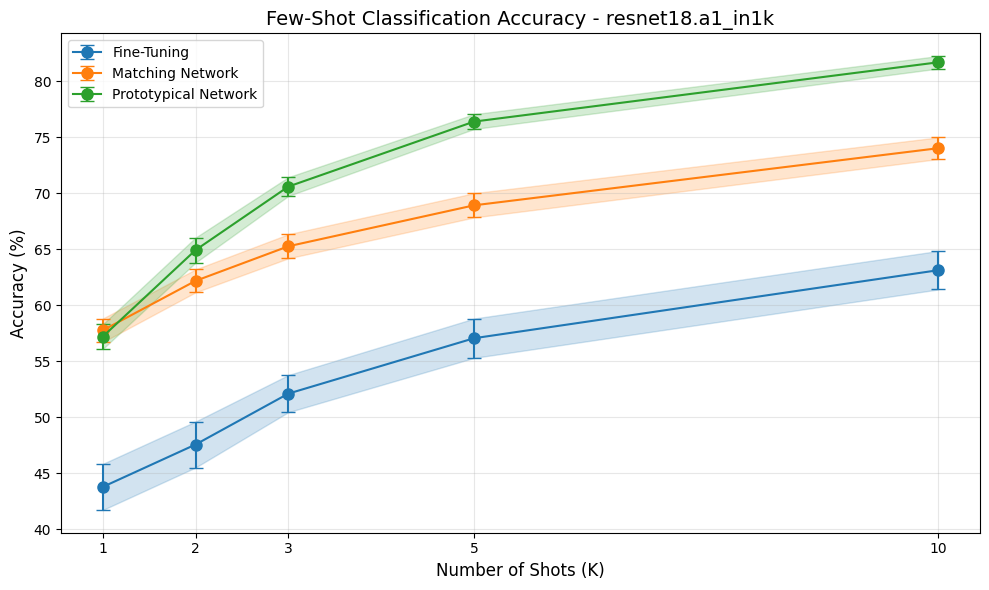

Saved plot to /Users/mac/Developer/VScode/Olive Pest Detector/results/classification/accuracy_vs_shots_resnet18_a1_in1k.png

Testing backbone: vit_tiny_patch16_224.augreg_in21k_ft_in1k

Computing embeddings with vit_tiny_patch16_224.augreg_in21k_ft_in1k...


Processing images: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]



Creating t-SNE visualization for vit_tiny_patch16_224.augreg_in21k_ft_in1k...


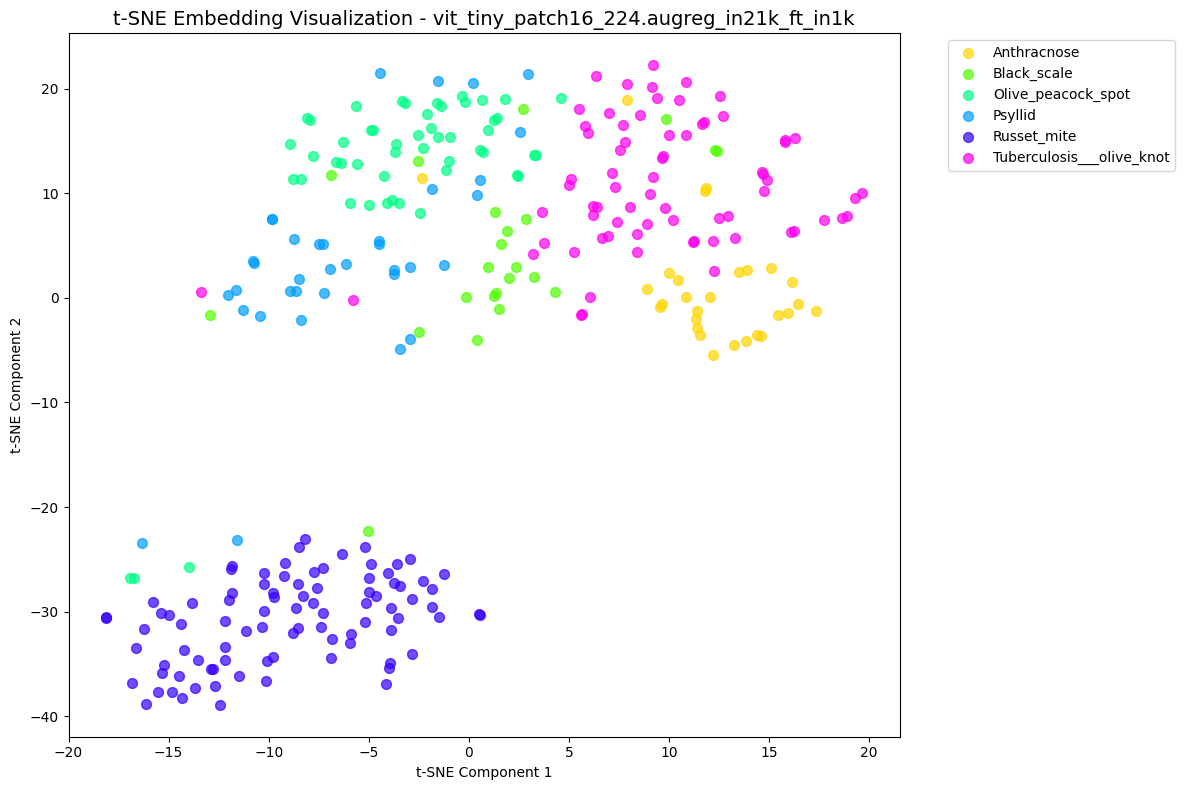

Saved t-SNE plot to /Users/mac/Developer/VScode/Olive Pest Detector/results/classification/tsne_visualization_vit_tiny_patch16_224_augreg_in21k_ft_in1k.png

--- 1-shot evaluation ---
Evaluating Prototypical Network with 1-shot...


Prototypical Network K=1: 100%|██████████| 100/100 [00:00<00:00, 418.19it/s]


  Prototypical Network: 63.59% (±1.40)
Evaluating Matching Network with 1-shot...


Matching Network K=1: 100%|██████████| 100/100 [00:00<00:00, 710.79it/s]


  Matching Network: 64.76% (±1.22)
Evaluating Fine-Tuning with 1-shot...


Fine-Tuning K=1: 100%|██████████| 100/100 [00:00<00:00, 116.25it/s]


  Fine-Tuning: 34.46% (±2.17)

--- 2-shot evaluation ---
Evaluating Prototypical Network with 2-shot...


Prototypical Network K=2: 100%|██████████| 100/100 [00:00<00:00, 381.31it/s]


  Prototypical Network: 72.26% (±1.05)
Evaluating Matching Network with 2-shot...


Matching Network K=2: 100%|██████████| 100/100 [00:00<00:00, 806.98it/s]


  Matching Network: 70.18% (±1.00)
Evaluating Fine-Tuning with 2-shot...


Fine-Tuning K=2: 100%|██████████| 100/100 [00:00<00:00, 113.81it/s]


  Fine-Tuning: 34.58% (±2.38)

--- 3-shot evaluation ---
Evaluating Prototypical Network with 3-shot...


Prototypical Network K=3: 100%|██████████| 100/100 [00:00<00:00, 412.03it/s]


  Prototypical Network: 77.61% (±0.95)
Evaluating Matching Network with 3-shot...


Matching Network K=3: 100%|██████████| 100/100 [00:00<00:00, 638.49it/s]


  Matching Network: 74.98% (±1.14)
Evaluating Fine-Tuning with 3-shot...


Fine-Tuning K=3: 100%|██████████| 100/100 [00:00<00:00, 113.35it/s]


  Fine-Tuning: 37.44% (±2.50)

--- 5-shot evaluation ---
Evaluating Prototypical Network with 5-shot...


Prototypical Network K=5: 100%|██████████| 100/100 [00:00<00:00, 383.74it/s]


  Prototypical Network: 82.97% (±0.66)
Evaluating Matching Network with 5-shot...


Matching Network K=5: 100%|██████████| 100/100 [00:00<00:00, 654.76it/s]


  Matching Network: 79.53% (±0.80)
Evaluating Fine-Tuning with 5-shot...


Fine-Tuning K=5: 100%|██████████| 100/100 [00:00<00:00, 117.85it/s]


  Fine-Tuning: 41.07% (±2.39)

--- 10-shot evaluation ---
Evaluating Prototypical Network with 10-shot...


Prototypical Network K=10: 100%|██████████| 100/100 [00:00<00:00, 337.84it/s]


  Prototypical Network: 87.19% (±0.48)
Evaluating Matching Network with 10-shot...


Matching Network K=10: 100%|██████████| 100/100 [00:00<00:00, 622.44it/s]


  Matching Network: 84.07% (±0.68)
Evaluating Fine-Tuning with 10-shot...


Fine-Tuning K=10: 100%|██████████| 100/100 [00:00<00:00, 121.08it/s]


  Fine-Tuning: 43.57% (±2.40)
Generating plot for vit_tiny_patch16_224.augreg_in21k_ft_in1k...


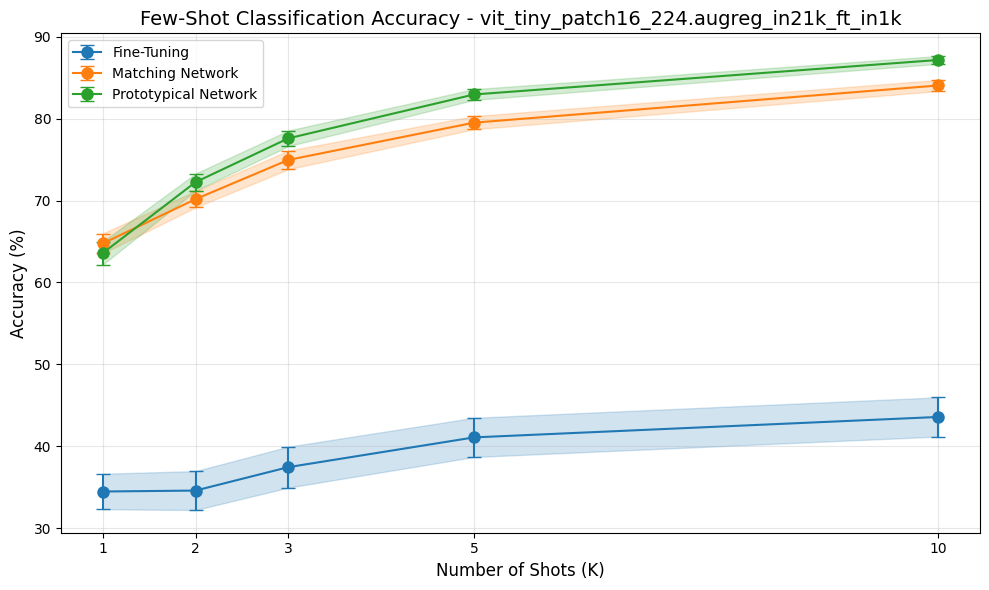

Saved plot to /Users/mac/Developer/VScode/Olive Pest Detector/results/classification/accuracy_vs_shots_vit_tiny_patch16_224_augreg_in21k_ft_in1k.png

FINAL RESULTS SUMMARY
          model_name  avg_accuracy_percent  confidence_interval_percent  shots                                  backbone
Prototypical Network             67.113014                     1.274758      1         tf_efficientnetv2_s.in21k_ft_in1k
    Matching Network             68.250000                     1.295020      1         tf_efficientnetv2_s.in21k_ft_in1k
         Fine-Tuning             61.506849                     1.306923      1         tf_efficientnetv2_s.in21k_ft_in1k
Prototypical Network             74.531469                     1.207738      2         tf_efficientnetv2_s.in21k_ft_in1k
    Matching Network             72.671329                     1.189084      2         tf_efficientnetv2_s.in21k_ft_in1k
         Fine-Tuning             69.818182                     1.198846      2         tf_efficientnet

In [9]:
# --- Simplified Main Execution ---
def run_backbone_experiments(backbone_name, all_image_paths, class_to_idx):
    """Run all experiments for a single backbone."""
    print(f"\n{'='*60}\nTesting backbone: {backbone_name}\n{'='*60}")
    
    # Compute embeddings
    path_to_embedding, embedding_dim = compute_all_embeddings(backbone_name, all_image_paths)
    
    # Create t-SNE visualization
    create_tsne_visualization(path_to_embedding, all_image_paths, backbone_name)
    
    # Run few-shot experiments
    results = []
    num_classes = len(class_to_idx)
    
    for k_shot in CONFIG["K_SHOTS_TO_TEST"]:
        print(f"\n--- {k_shot}-shot evaluation ---")
        
        # Test all models
        models = {
            "Prototypical Network": PrototypicalNetwork(),
            "Matching Network": MatchingNetwork(), 
            "Fine-Tuning": FineTuningModel(embedding_dim, num_classes)
        }
        
        for model_name, model in models.items():
            result = evaluate_model(model, model_name, k_shot, all_image_paths, 
                                  class_to_idx, path_to_embedding)
            result['backbone'] = backbone_name
            results.append(result)
    
    # Plot results for this backbone
    results_df = pd.DataFrame(results)
    plot_accuracy_results(results_df, backbone_name)
    
    return results

def main():
    """Main execution function."""
    print("Starting Few-Shot Classification Experiments")
    print(f"Device: {CONFIG['DEVICE']}")
    
    # Setup
    os.makedirs(CONFIG["OUTPUT_DIR"], exist_ok=True)
    all_image_paths, class_to_idx = load_dataset()
    
    # Run experiments for each backbone
    all_results = []
    for backbone in CONFIG["BACKBONES_TO_TEST"]:
        backbone_results = run_backbone_experiments(backbone, all_image_paths, class_to_idx)
        all_results.extend(backbone_results)
    
    # Save comprehensive results
    if all_results:
        results_df = pd.DataFrame(all_results)
        print("\n" + "="*60)
        print("FINAL RESULTS SUMMARY")
        print("="*60)
        print(results_df.to_string(index=False))
        
        csv_path = os.path.join(CONFIG["OUTPUT_DIR"], "full_accuracy_summary.csv")
        results_df.to_csv(csv_path, index=False)
        print(f"\n✅ Results saved to: {csv_path}")

# Run experiments
if __name__ == '__main__':
    main()